## Vamos Começar

Baixar e Instalar o [Anaconda](https://www.continuum.io/downloads) (Distribuição Python)

Inicializar o Spyder (IDE Python)

![](../resource/spyder.png)

1. Editor de arquivos
1. Inspetor de Variáveis
1. Console Python

**Atalhos Importantes:**

+ Ctrl+Espaço - Lista de Funções
+ Ctrl+I - Mostra Documentação
+ Ctrl+Shift+I - Foco no Console
+ Ctrl+Shift+V - Foco Inspetor de Variáveis
+ Ctrl+Shift+E - Foco no Editor
+ F5 - Executa Script


## Exercício - Análise de Poço por Curvas de Declínio

![](https://upload.wikimedia.org/wikipedia/commons/thumb/6/67/GlennPool.jpg/220px-GlennPool.jpg)

*Baseado no Exemplo 11.1 do livro [Engenharia de Reservatórios de Petróleo](http://www.saraiva.com.br/engenharia-de-reservatorios-de-petroleo-198191.html) de Rosa, A. et al.*

>Método simplificado e bastante usado na prática para a realização de ajuste de histórico e/ou previsão do comportamento de poços isolados (Rosa, A. et al, 2006)
 
Dado o histórico de produção de um poço na tabela abaixo:

| *t (ano)* | *q (m³std/d)* |
|-----------|---------------|
| 0         | 100           |
| 1         | 77.0          |
| 2         | 61.0          |
| 3         | 49.5          |
| 4         | 41.0          |
| 5         | 34.5          |

Considerando uma vazão de abandono de 5 m³std/d, determinar, através de análise de curva de declínio:

 1. Tempo de abandono;
 1. Produção acumulada até o abandono.


Vamos criar uma lista com os dados do histórico

In [52]:
qm = [100, 77, 61, 49.5, 41, 34.5]

**Listas não são Arrays!**

|Lista                            |Array               |
|:-------------------------------:|:------------------:|
|![](../resource/paperbox.jpg) |![](../resource/beerbox.jpg)|

In [5]:
import numpy as np

In [6]:
qm = np.array([100, 77, 61, 49.5, 41, 34.5])
t = np.arange(6)

[Exemplo lendo dados do Excel](#Lendo-dados-do-Excel)

#### Plot

In [7]:
import matplotlib.pyplot as plot
%matplotlib inline

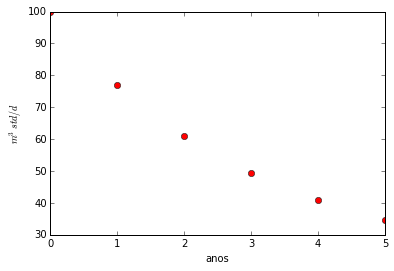

In [8]:
plot.plot(t, qm, "ro")
plot.xlabel("anos")
plot.ylabel("$m^3 std/d$")

#### Funções

Utilizando a equação de Declínio Hiperbólico, a vazão $q$ de um poço no tempo $t$ pode é dada por:

$$q = \frac{q_i}{(1 + n a_i t)^{1/n}}$$

Podemos escrever esta equação em Python da seguinte forma:

In [9]:
def well_flow(t, qi, ai, n):
    '''
    Calculate well flow rate using decline curve analysis
    '''
    return qi / (1 + n * ai * t) ** (1 / n)

Tipagem dinâmica e foco na legibilidade

Exemplo da mesma função em C:

Como nossos vetores tem suporte a operadores, podemos chamar a função passando um valor escalar ou os próprios vetores:

In [10]:
# using a scalar
well_flow(2, 100, 0.3, 1/3)

57.87037037037038

In [11]:
# using an array
well_flow(t, 100, 0.3, 1/3)

array([ 100.        ,   75.13148009,   57.87037037,   45.51661356,
         36.44314869,   29.62962963])

Plotando

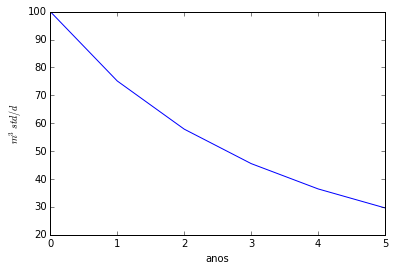

In [12]:
qs = well_flow(t, 100, 0.3, 1/3)
plot.plot(t, qs)
plot.xlabel("anos")
plot.ylabel("$m^3 std/d$")

Usaremos a função [curve_fit][curve-fit] da [SciPy][scipy-ref] para encontrar os parâmetros da curva de declínio para nossos dados de histórico:

[scipy-ref]: http://docs.scipy.org/doc/scipy-0.14.0/reference/index.html
[curve-fit]: http://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.optimize.curve_fit.html

In [13]:
from scipy.optimize import curve_fit

params, fitted = curve_fit(well_flow, t, qm, p0=[100, 0.3, 1/3])
qi, ai, n = params

Podemos imprimir o resultad usando [formatação de strings](https://docs.python.org/3/library/string.html#format-specification-mini-language)

In [15]:
print("Qi: %.2f m³std/d, ai: %.3f, n: %.3f" % (qi, ai, n))

Qi: 100.01 m³std/d, ai: 0.280, n: 0.489


Plotando contra os dados de histórico, temos:

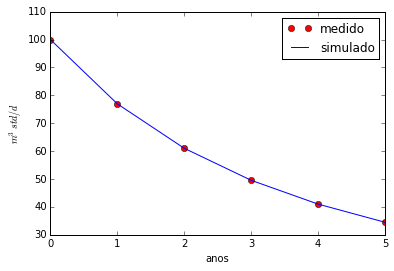

In [16]:
qs = well_flow(t, qi, ai, n)
plot.plot(t, qm, "ro", label="medido")
plot.plot(t, qs, label="simulado")
plot.xlabel("anos")
plot.ylabel("$m^3 std/d$")
plot.legend()

Para encontrar o tempo de abandono, vamos isolar $t$ na equação de declíneo:

$$q = \frac{q_i}{(1 + n a_i t)^{1/n}}$$

temos:

$$t = \frac{(q_i/q)^n - 1}{n a_i}$$


In [17]:
def abandon_time(q, qi, ai, n):
    return ((qi/q)**n - 1) / (ai*n)

In [20]:
ta = 5
abandon_time(ta, qi, ai, n)

24.36224982496239

Temos que o tempo de abandono é de **24.36 anos**

A produção acumulada até o abandono pode ser calculada integrando-se o a função de declíneo no interavlo de produção $(0, 24.36)$. Para isso vamos usar a função [quad][quad] da [SciPy][scipy-ref].

[scipy-ref]: http://docs.scipy.org/doc/scipy-0.14.0/reference/index.html
[quad]: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.integrate.quad.html#scipy.integrate.quad

In [21]:
from scipy.integrate import quad

result, error = quad(well_flow, 0, 24.4, (params[0], params[1], params[2]))
Np = result * 365.25
print(Np) # mult by 365 since flow is in days

200576.92524981254


Produção acumulada até o tempo de abandono de **200.576 m³std**

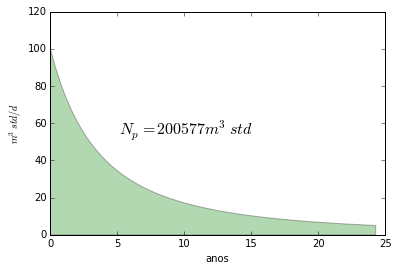

In [22]:
t = np.linspace(0, 24.3, 100)
q = well_flow(t, qi, ai, n)

plot.fill_between(t, q, 0, facecolor='g', alpha=0.3)
plot.annotate(r"$N_p = %.0f m^3std$" % Np, xy=(0.3, 0.5), xycoords='figure fraction', size=16)
plot.xlabel("anos")
plot.ylabel("$m^3 std/d$")

### Links Interessantes

- [SciPy - Referênciia](http://docs.scipy.org/doc/scipy/reference/)
- [Matplotlib Gallery](http://matplotlib.org/gallery.html)
- [Numpy for Matlab users](https://docs.scipy.org/doc/numpy-dev/user/numpy-for-matlab-users.html#general-purpose-equivalents)

### Round Bônus

In [33]:
import yahoo_finance
brent_share = yahoo_finance.Share("BZZ15.NYM")
usd_curr = yahoo_finance.Currency("USDBRL")
brent_price = float(brent_share.get_price())
usd = float(usd_curr.get_rate())
"Brent: %.2f - Dólar: %.2f" % (brent_price, usd)


'Brent: 47.68 - Dólar: 3.77'

In [51]:
import locale
# Definindo locale para as configurações regionais da máquina
locale.setlocale(locale.LC_ALL, "")
# Imprimindo valor em moeda corrente, agrupand milhar
locale.currency(Np * 6.28981077 * brent_price * usd, grouping=True)

'R$ 226.829.644,23'